<a href="https://colab.research.google.com/github/Querent-ai/pytorch_research/blob/main/Facies_MLP_98_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[Facies Prediction with Class Weighting & Visualization](https://)**

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [7]:
df = pd.read_csv("mcmurray_facies_v1.csv")  # Change path as needed
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.dropna(subset=['GR', 'RHOB', 'NPHI', 'PHI', 'VSH', 'lithName'])  # Drop rows missing features/target


<ipython-input-7-8f28c2b40e49>:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("mcmurray_facies_v1.csv")  # Change path as needed


In [9]:
features = ['GR', 'RHOB', 'NPHI', 'PHI', 'VSH']
target = 'lithName'

X = df[features].values
y = df[target].values


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [11]:
counts = Counter(y_encoded)
valid_labels = [label for label, count in counts.items() if count >= 2]
mask = np.isin(y_encoded, valid_labels)

X_filtered = X_scaled[mask]
y_filtered = y_encoded[mask]

# Re-encode filtered labels for consistency
le_filtered = LabelEncoder()
y_filtered = le_filtered.fit_transform(y_filtered)
classes = le_filtered.classes_


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)


In [13]:
class FaciesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(FaciesDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(FaciesDataset(X_test, y_test), batch_size=64)


In [14]:
class FaciesMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model = FaciesMLP(input_dim=len(features), hidden_dim=64, output_dim=len(classes))
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
for epoch in range(1000):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.3405
Epoch 2, Loss: 0.3141
Epoch 3, Loss: 0.3141
Epoch 4, Loss: 0.3032
Epoch 5, Loss: 0.3038
Epoch 6, Loss: 0.2989
Epoch 7, Loss: 0.2813
Epoch 8, Loss: 0.2704
Epoch 9, Loss: 0.2683
Epoch 10, Loss: 0.2611
Epoch 11, Loss: 0.2697
Epoch 12, Loss: 0.2572
Epoch 13, Loss: 0.2502
Epoch 14, Loss: 0.2544
Epoch 15, Loss: 0.2468
Epoch 16, Loss: 0.2331
Epoch 17, Loss: 0.2290
Epoch 18, Loss: 0.2324
Epoch 19, Loss: 0.2150
Epoch 20, Loss: 0.2143
Epoch 21, Loss: 0.2109
Epoch 22, Loss: 0.2142
Epoch 23, Loss: 0.2136
Epoch 24, Loss: 0.2105
Epoch 25, Loss: 0.2216
Epoch 26, Loss: 0.1985
Epoch 27, Loss: 0.1948
Epoch 28, Loss: 0.2039
Epoch 29, Loss: 0.2005
Epoch 30, Loss: 0.1928
Epoch 31, Loss: 0.1867
Epoch 32, Loss: 0.1944
Epoch 33, Loss: 0.1895
Epoch 34, Loss: 0.1906
Epoch 35, Loss: 0.1865
Epoch 36, Loss: 0.1799
Epoch 37, Loss: 0.1776
Epoch 38, Loss: 0.1857
Epoch 39, Loss: 0.1831
Epoch 40, Loss: 0.1763
Epoch 41, Loss: 0.1756
Epoch 42, Loss: 0.1779
Epoch 43, Loss: 0.1666
Epoch 44, Loss: 0.17

In [18]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(yb.numpy())

print(classification_report(all_labels, all_preds, target_names=[str(c) for c in classes], zero_division=0))
cm = confusion_matrix(all_labels, all_preds)


              precision    recall  f1-score   support

           0       0.37      0.94      0.53        16
           1       0.99      0.98      0.99      1171
           2       1.00      0.98      0.99      1604
           3       0.77      1.00      0.87        92
           4       0.99      0.98      0.98      1237
           5       0.99      0.99      0.99      1178
           6       0.87      1.00      0.93        34

    accuracy                           0.98      5332
   macro avg       0.85      0.98      0.90      5332
weighted avg       0.99      0.98      0.98      5332



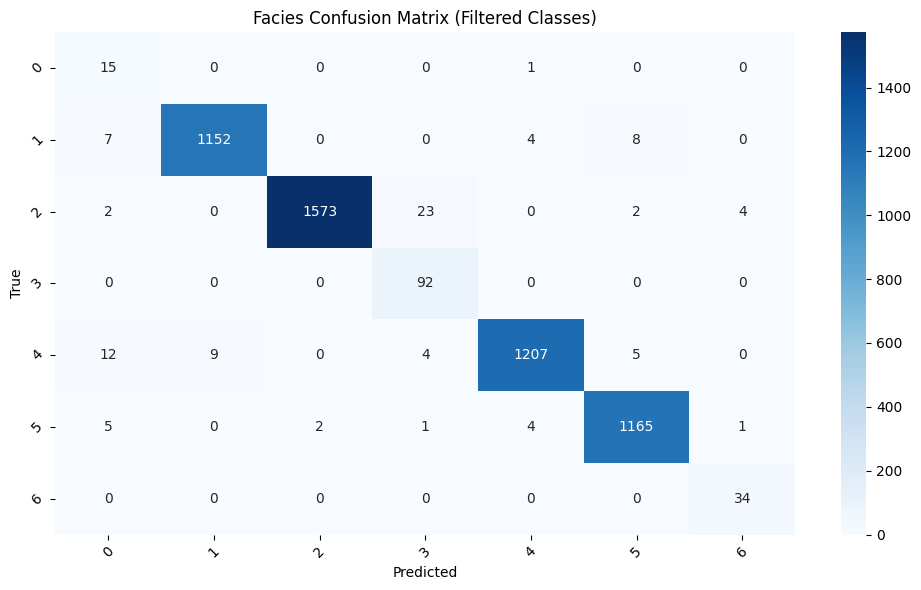

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Facies Confusion Matrix (Filtered Classes)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
